In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from process import get_processed_data
df = get_processed_data(transform=False)

In [45]:
plt.rcParams.update({'figure.figsize': [9, 9]})

Target of this notebook is to understand the statistical correlation/dependency between erosion rate and other values in the data. This allows to understand if a value can be imputed by means of statistics instead of being measured. 

## Preprocessing
To work with the data, few colums have to be dropped as they don't provide useful information. It might be interesting to correlate the papers or authors with their measured data, but, despite the possibility to find out who has conducted measurements properly, won't yield relevant insights.

In [2]:
df.drop('Paper', 1, inplace=True)
df.drop('Unnamed: 0', 1, inplace=True)
df.drop('Name', 1, inplace=True)

## Problematic Rows
In the following we have a look at rows containing null values. The particular reason for these values is unknown to us. However, due to their small number of 9, we can drop these rows. Further, we do not see a reason why these rows should be kept as missing data rather indicates missing resources for good measurements. Thus, we probably do not want to analyze these rows.

In [3]:
for c in df.columns:
    if any(pd.isnull(df[c])):
        print('Number of rows containing null values in column', c, ':', pd.isnull(df[c]).sum())

Number of rows containing null values in column Effective basin elevation (m) : 4
Number of rows containing null values in column Mean Basin slope : 4
Number of rows containing null values in column Rock type : 4
Number of rows containing null values in column Mean annual precipitation (mm/yr) : 4
Number of rows containing null values in column Mean annual Temperature (C) : 4
Number of rows containing null values in column % Vegetation : 4
Number of rows containing null values in column Seismicity : 4
Number of rows containing null values in column Climate zone main : 4
Number of rows containing null values in column Cronus erosion rate (m/My) : 8
Number of rows containing null values in column Cronus erosion rate error (m/My) : 9


In [4]:
print('Number of rows containing at least one null value:', df.isnull().any(1).sum())

Number of rows containing at least one null value: 9


We simply remove these rows from our table:

In [5]:
df.dropna(axis=0, how='any', inplace=True)
print('Leaving us with', df.isnull().any(1).sum(), 'rows containing null values')

Leaving us with 0 rows containing null values


Further, we observe rows containing Latitude and Longitude cells, which are provided in another format. For example, we have 1150 instead of 682778 instead of 68.2778 for Latitude. In the following these values are fixed. The factors of 1e4 and 1e3 can be retrieved from the data.

In [6]:
df.Latitude = df.Latitude.apply(lambda x: x if x <= 180 else x/1e4)
df.Longitude = df.Longitude.apply(lambda x: x if x <= 180 else x/1e3)

## Data Types

The provided data contains both categorical and continuous data. In the following we will treat both separately. While we are interested in the distribution of the continuous data, we describe the categorical data only shallowly.

In the following cell the continuous and cateogorical column names are depicted.

In [24]:
cont = ['Latitude', 'Longitude', 'Mean basin elevation (m)', 'Basin Relief (m)', 'Basin Area (km2)', 
        'Mean Latutide (dec. Deg.)', 'Mean Longitude (dec. Deg)', 'Effective basin elevation (m)',
        'Mean Basin slope', 'Mean annual precipitation (mm/yr)', 'Mean annual Temperature (C)', 
        '% Vegetation', 'Seismicity', 'Cronus erosion rate (m/My)', 'Cronus erosion rate error (m/My)']

cat = ['Seismic regime', 'Climate zone main', 'Rock type']
assert len(cont + cat) == len(df.columns)

We can thus calculate the coefficients, which are usually interesting. This allows us to see problems in the data and also allows to grasp the idea of the data. For example, the column denoting _Basin Area (km²)_ depicts suspicious data as the max value is extremely large (1695910 km²), which describes an area more than three times bigger than Germany. 

In [27]:
df[cont].describe()

,Latitude,Longitude,Mean basin elevation (m),Basin Relief (m),Basin Area (km2),Mean Latutide (dec. Deg.),Mean Longitude (dec. Deg),Effective basin elevation (m),Mean Basin slope,Mean annual precipitation (mm/yr),Mean annual Temperature (C),% Vegetation,Seismicity,Cronus erosion rate (m/My),Cronus erosion rate error (m/My)
count,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000,1141.000000
mean,25.239462,-24.285144,1666.219106,1276.024540,11151.906152,24.927079,-19.562753,1705.063103,15.085455,1002.037686,9.980719,43.391762,1.248778,204.571788,33.012445
std,24.033130,85.687149,1211.574082,1420.841427,79062.211786,23.622943,85.944558,1230.195247,8.889936,635.755296,6.702158,29.356668,1.123772,436.057905,84.188874
min,-36.667000,-124.240000,15.000000,-1.000000,0.000000,-36.636000,-124.099000,14.000000,0.800000,4.000000,-5.000000,0.000000,0.000000,0.340000,-43.000000
25%,9.357000,-83.878000,669.000000,331.000000,2.820000,9.349000,-83.657000,684.000000,7.200000,593.000000,6.000000,13.000000,0.444207,20.910000,1.760000
50%,34.410000,-67.675000,1433.000000,803.000000,16.350000,34.386000,-64.890000,1458.000000,14.300000,868.000000,9.000000,44.000000,0.855054,48.360000,4.890000
75%,40.155000,48.204000,2179.000000,1656.000000,302.370000,40.144000,79.352000,2231.000000,21.700000,1245.000000,15.000000,76.000000,1.841031,163.290000,20.140000
max,150.162000,150.000000,5057.000000,7265.000000,1695910.000000,50.034000,150.182000,5069.000000,42.800000,3265.000000,27.000000,80.000000,5.934140,4537.480000,1006.730000


## Univariate Distribution of Continuous Data

This section deals with analyzing and plotting the distribution of continuous data. The idea is to get a general idea of the distribution. For example, this allows to reason the necessity of scaling the data into another space, such as using a polynomial scaling, which transforms values $x\in R$ by applying a polynomial of degree a to $x'=x^a$. We will plot the univariate distribution for continuous data and try to explain the observations.

### Longitude and Latitude
Neither of the values are unexpected. The world map already shows the distribution along both _axes_. These two plots depicte the same information but provide the degrees, where the most samples were retrieved. The combination of the most common lateral and longitudinal degrees approximately yields (40, -100), which is in the US.

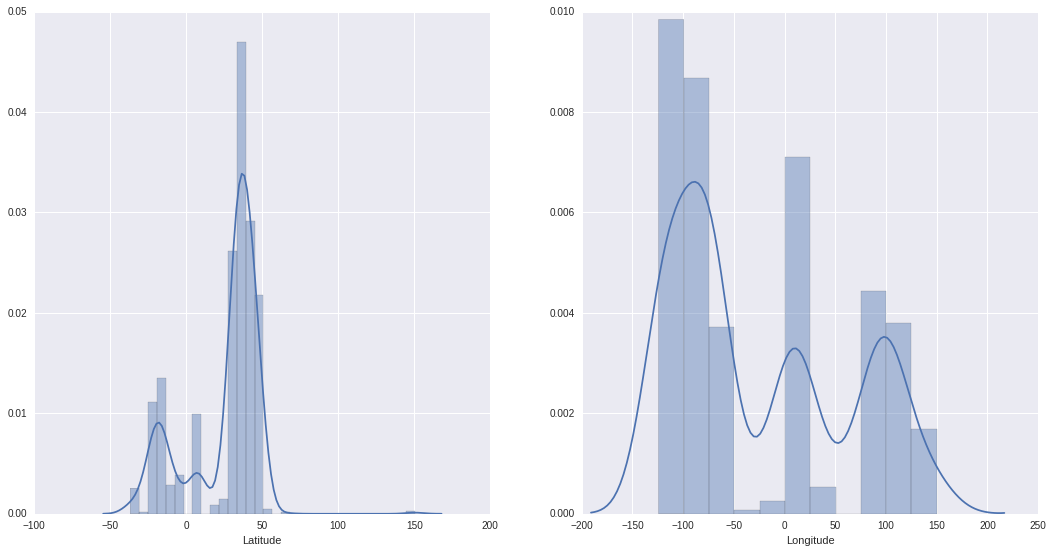

In [38]:
fig = plt.figure(figsize=(18, 9))
ax_lat = fig.add_subplot(121)
ax_lon = fig.add_subplot(122)
sns.distplot(df['Latitude'], ax=ax_lat)
sns.distplot(df['Longitude'], ax=ax_lon)
plt.show()

Since latitude and longitude are known to be dependent, we also provide a pairplot of the distribution. This results in a plot, which can be interpreted as a map.

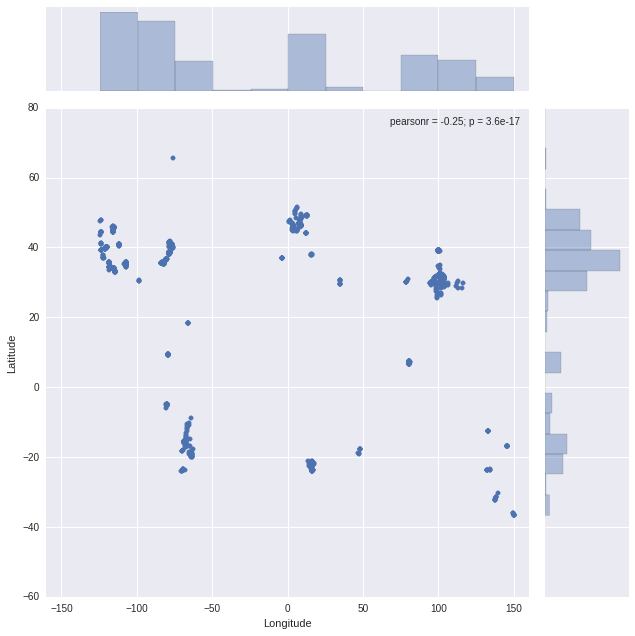

In [54]:
sns.jointplot(y='Latitude', x='Longitude', data=df, xlim=(-160, 160), ylim=(-60, 80), size=9)
plt.show()

In [55]:
cont

['Latitude',
 'Longitude',
 'Mean basin elevation (m)',
 'Basin Relief (m)',
 'Basin Area (km2)',
 'Mean Latutide (dec. Deg.)',
 'Mean Longitude (dec. Deg)',
 'Effective basin elevation (m)',
 'Mean Basin slope',
 'Mean annual precipitation (mm/yr)',
 'Mean annual Temperature (C)',
 '% Vegetation',
 'Seismicity',
 'Cronus erosion rate (m/My)',
 'Cronus erosion rate error (m/My)']

### Basin Elevation and Relief

Basin elevation and relief are provided in meters and provide additional geographic information about the position where the experiments were conducted. More specifically, these data provide the altitude of

In [31]:
len(df[df['Basin Area (km2)'] == 0])

22

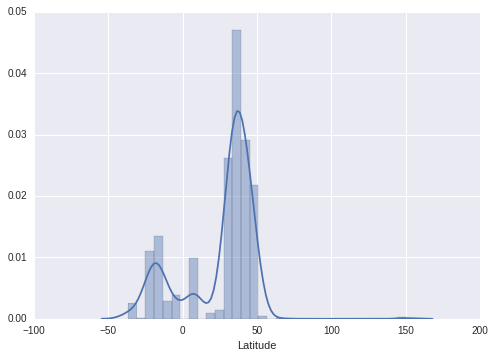

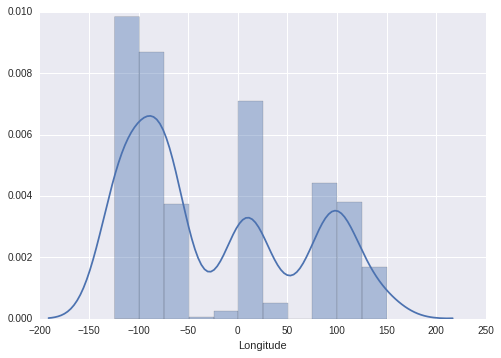

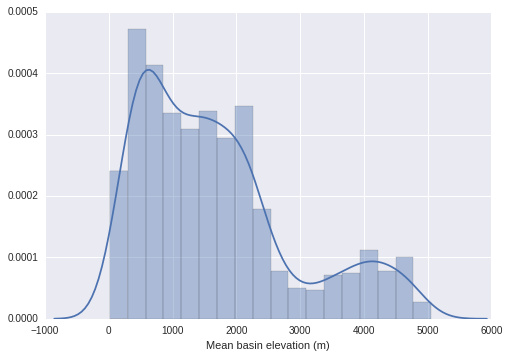

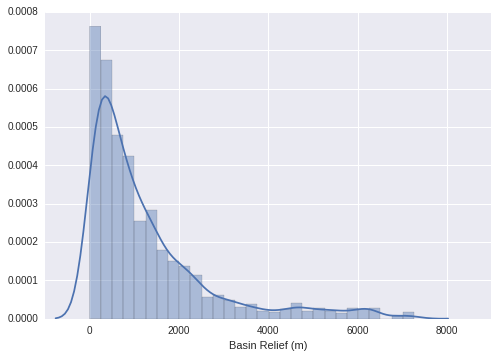

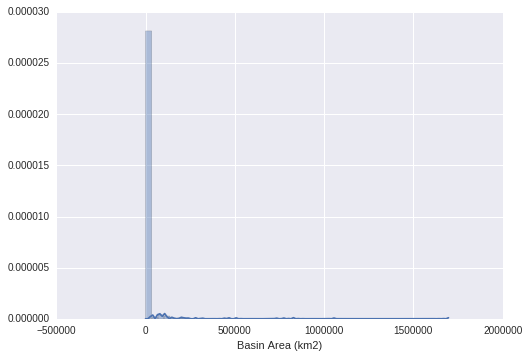

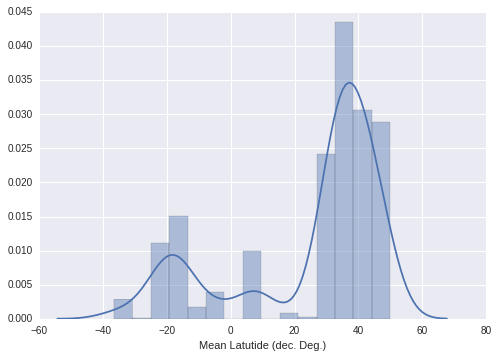

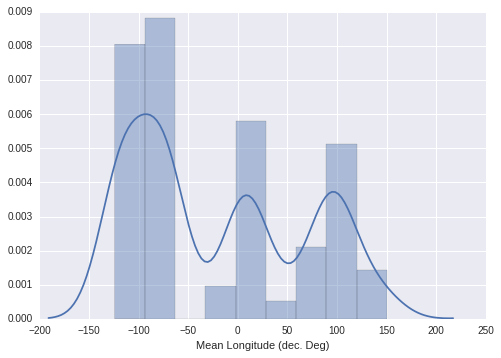

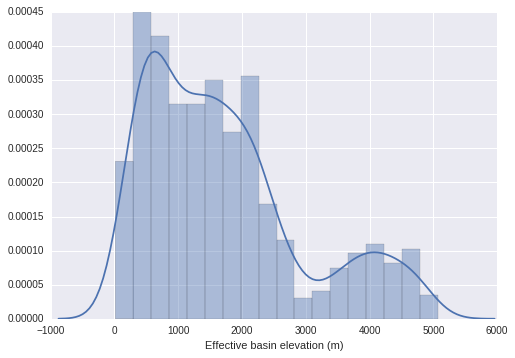

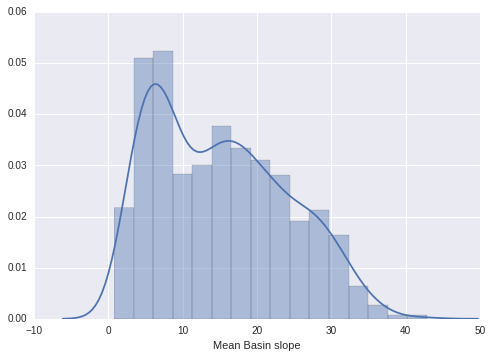

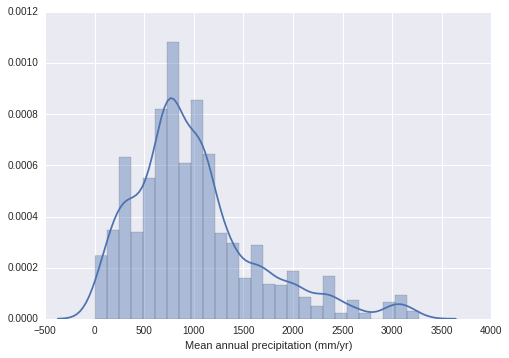

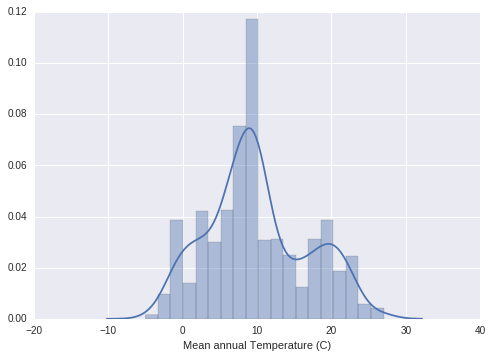

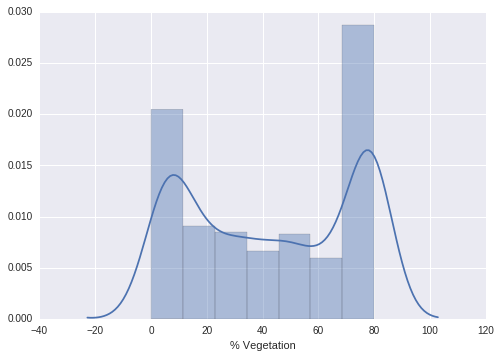

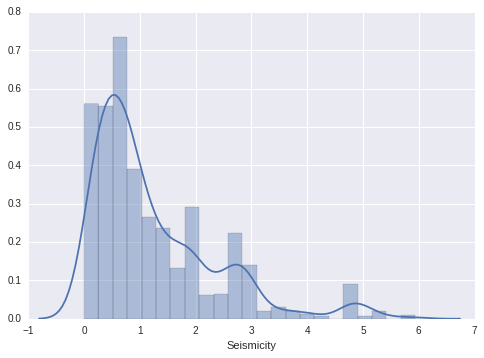

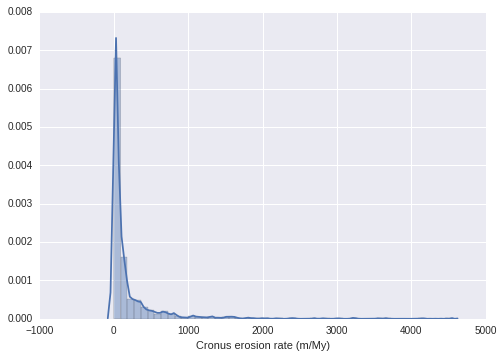

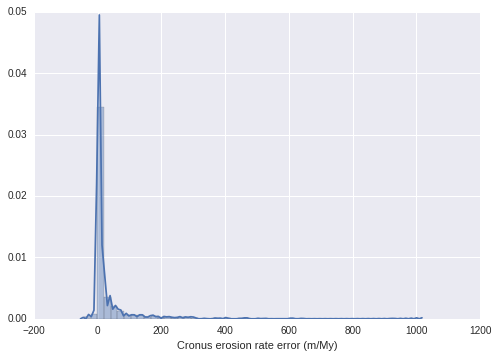

In [29]:
for c in cont:
    sns.distplot(df[c])
    plt.show()

In [12]:
for c in ['Rock type', 'Seismic regime', 'Climate zone main']:
    print(set(df[c]))

{'Sedimentary', 'Metamorphic', 'Mixed', 'Igneous'}
{0.0, 1.0}
{'Temperate', 'Arid', 'Tropical', 'Polar', 'Cold'}


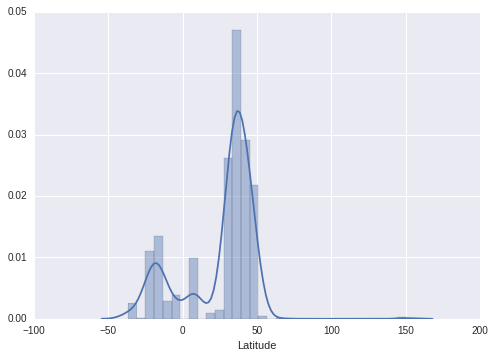

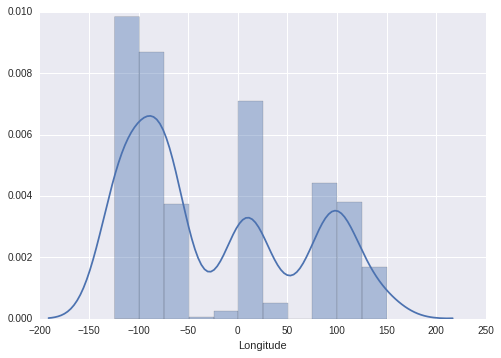

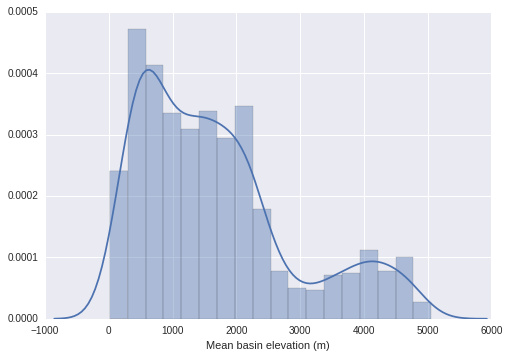

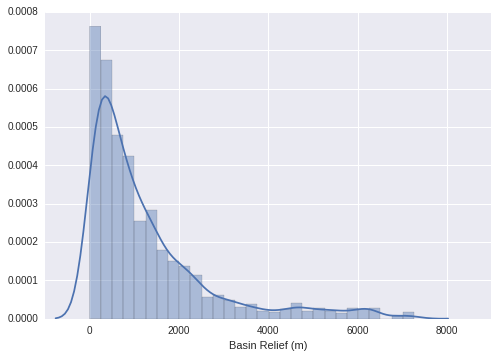

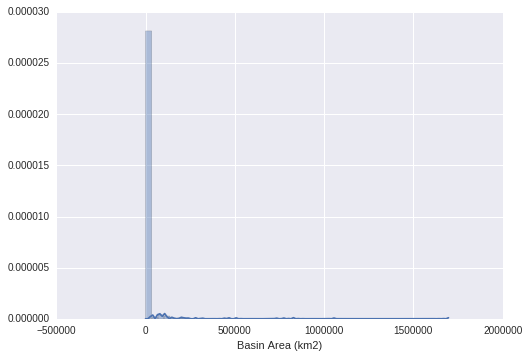

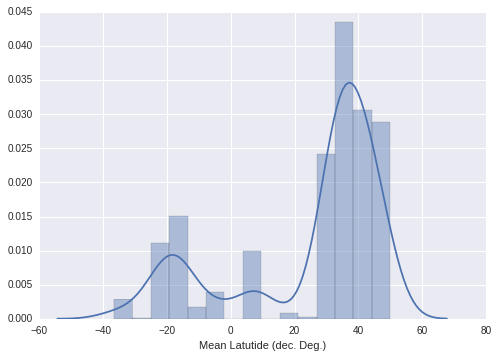

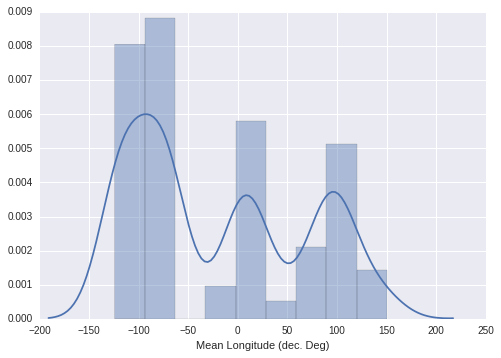

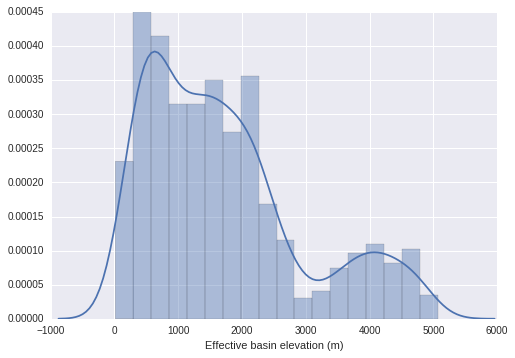

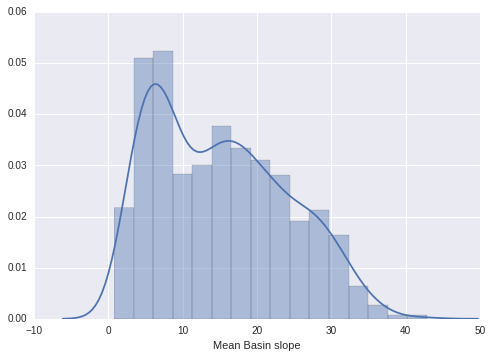

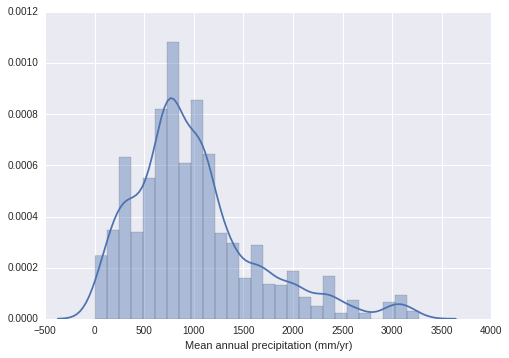

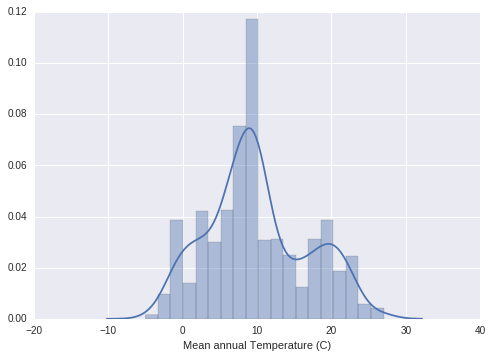

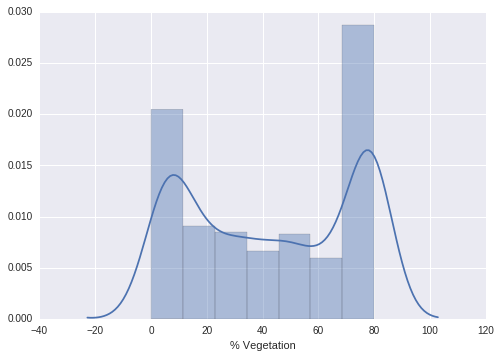

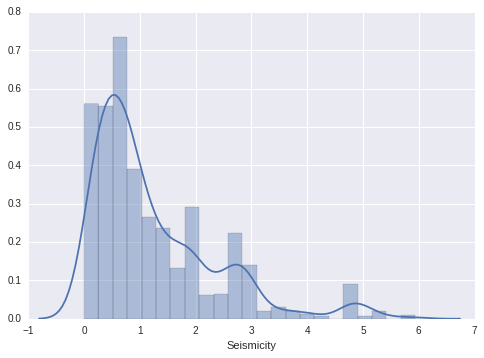

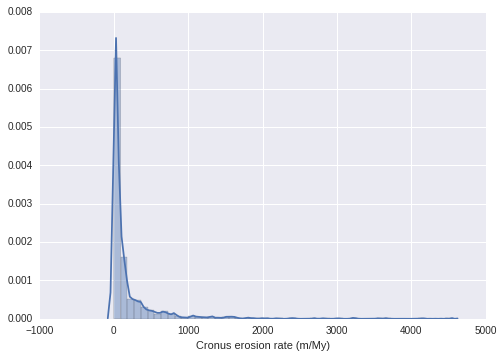

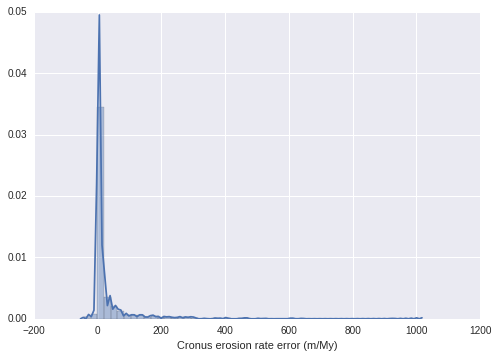

In [ ]:
len(df.Latitude)

In [ ]:
df.columns.values

In [ ]:
from process import read_data
df_raw = read_data()
df_important = pd.DataFrame()
df_important["Mean Basin slope"] = df["Mean Basin slope"]
df_important["Rock type"] = df_raw["Rock type"]
df_important["Cronus erosion rate (m/My)"] = df["Cronus erosion rate (m/My)"]
df_important["Mean annual precipitation (mm/yr)"] = df["Mean annual precipitation (mm/yr)"]
df_important["% Vegetation"] = df["% Vegetation"]

In [ ]:
df_important = df_important.dropna()
df_important

In [ ]:
sb.pairplot(df_important, kind='reg')